## Requirements

In [2]:
!pip install -q -r requirements.txt

ERROR: Could not find a version that satisfies the requirement triton (from versions: none)
ERROR: No matching distribution found for triton


In [2]:
# reload modules before executing user code
%load_ext autoreload
%autoreload 2

In [3]:
from utils import set_random_seed

RANDOM_STATE = 42
set_random_seed(RANDOM_STATE)

In [4]:
"""from utils import download_dataset_folder

download_dataset_folder(version_number=1)"""

'from utils import download_dataset_folder\n\ndownload_dataset_folder(version_number=1)'

## Data & Model

In [5]:
from huggingface_hub import hf_hub_download
import os

if os.path.exists('./checkpoints') == False:
    os.mkdir('./checkpoints')

vae_path = hf_hub_download(repo_id="stabilityai/sd-vae-ft-mse-original", filename="vae-ft-mse-840000-ema-pruned.safetensors")
realisticVision_path = hf_hub_download(repo_id="SG161222/Realistic_Vision_V5.1_noVAE", filename="Realistic_Vision_V5.1-inpainting.safetensors")
lora_path = hf_hub_download(repo_id="maidacundo/lora-arked-facades", filename='lora_white_wall.pt')

In [6]:
from diffusers import (
    AutoencoderKL,
    StableDiffusionInpaintPipeline,
    DDIMScheduler,
)
import torch
from pipeline_inpainting_logprob_v2 import DPPOStableDiffusionInpaintPipeline

vae = AutoencoderKL.from_single_file(
    vae_path,
)

from diffusers import (
    AutoencoderKL,
    StableDiffusionInpaintPipeline,
)

vae = AutoencoderKL.from_single_file(
    vae_path,
)

pipe = StableDiffusionInpaintPipeline.from_single_file(
    realisticVision_path,
    vae=vae,
    safety_checker=None,
    torch_dtype=torch.float16,
)

dppo_pipe = DPPOStableDiffusionInpaintPipeline(
    vae=pipe.vae,
    text_encoder=pipe.text_encoder,
    tokenizer=pipe.tokenizer,
    unet=pipe.unet,
    scheduler=pipe.scheduler,
    safety_checker=None,
    feature_extractor=pipe.feature_extractor,
    requires_safety_checker=False,
    lora_path=lora_path,
)

dppo_pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

del pipe

dppo_pipe.enable_model_cpu_offload()
dppo_pipe.enable_xformers_memory_efficient_attention()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.


injecting lora...


A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [7]:
# print sum of trainable parameters
total_params = sum(p.numel() for p in dppo_pipe.unet.parameters())
trainable_params = sum(p.numel() for p in dppo_pipe.unet.parameters() if p.requires_grad) # 24929284
print(f"Total parameters U-Net: {total_params}")
print(f"Trainable parameters U-Net: {trainable_params}")

Total parameters U-Net: 862028292
Trainable parameters U-Net: 2492928


In [8]:
from accelerate import Accelerator
from accelerate.utils import set_seed, ProjectConfiguration
from accelerate.logging import get_logger

In [9]:
import ml_collections

config = ml_collections.ConfigDict()

###### General ######
# run name for wandb logging and checkpoint saving -- if not provided, will be auto-generated based on the datetime.
config.run_name = ""
# random seed for reproducibility.
config.seed = 42
# top-level logging directory for checkpoint saving.
config.logdir = "logs"
# number of epochs to train for. each epoch is one round of sampling from the model followed by training on those samples.
config.num_epochs = 10
# number of epochs between saving model checkpoints.
config.save_freq = 20
# number of checkpoints to keep before overwriting old ones.
config.num_checkpoint_limit = 5
# mixed precision training. options are "fp16", "bf16", and "no". half-precision speeds up training significantly.
config.mixed_precision = "no"
# resume training from a checkpoint. either an exact checkpoint directory (e.g. checkpoint_50), or a directory
# containing checkpoints, in which case the latest one will be used. `config.use_lora` must be set to the same value
# as the run that generated the saved checkpoint.
config.resume_from = ""
# whether or not to use LoRA. LoRA reduces memory usage significantly by injecting small weight matrices into the
# attention layers of the UNet. with LoRA, fp16, and a batch size of 1, finetuning Stable Diffusion should take
# about 10GB of GPU memory. beware that if LoRA is disabled, training will take a lot of memory and saved checkpoint
# files will also be large.
config.use_lora = True

###### Sampling ######
config.sample = sample = ml_collections.ConfigDict()
# number of sampler inference steps.
sample.num_steps = 20
# eta parameter for the DDIM sampler. this controls the amount of noise injected into the sampling process, with 0.0
# being fully deterministic and 1.0 being equivalent to the DDPM sampler.
sample.eta = 1.0
# classifier-free guidance weight. 1.0 is no guidance.
sample.guidance_scale = 7.5
# batch size (per GPU!) to use for sampling.
sample.batch_size = 1
# number of batches to sample per epoch. the total number of samples per epoch is `num_batches_per_epoch *
# batch_size * num_gpus`.
sample.num_batches_per_epoch = 2
 
###### Training ######
config.train = train = ml_collections.ConfigDict()
# batch size (per GPU!) to use for training.
train.batch_size = 1
# whether to use the 8bit Adam optimizer from bitsandbytes.
train.use_8bit_adam = False
# learning rate.
train.learning_rate = 3e-4
# Adam beta1.
train.adam_beta1 = 0.9
# Adam beta2.
train.adam_beta2 = 0.999
# Adam weight decay.
train.adam_weight_decay = 1e-4
# Adam epsilon.
train.adam_epsilon = 1e-8
# number of gradient accumulation steps. the effective batch size is `batch_size * num_gpus *
# gradient_accumulation_steps`.
train.gradient_accumulation_steps = 1
# maximum gradient norm for gradient clipping.
train.max_grad_norm = 1.0
# number of inner epochs per outer epoch. each inner epoch is one iteration through the data collected during one
# outer epoch's round of sampling.
train.num_inner_epochs = 1
# whether or not to use classifier-free guidance during training. if enabled, the same guidance scale used during
# sampling will be used during training.
train.cfg = True
# clip advantages to the range [-adv_clip_max, adv_clip_max].
train.adv_clip_max = 5
# the PPO clip range.
train.clip_range = 1e-4
# the fraction of timesteps to train on. if set to less than 1.0, the model will be trained on a subset of the
# timesteps for each sample. this will speed up training but reduce the accuracy of policy gradient estimates.
train.timestep_fraction = 1.0


###### Per-Prompt Stat Tracking ######
# when enabled, the model will track the mean and std of reward on a per-prompt basis and use that to compute
# advantages. set `config.per_prompt_stat_tracking` to None to disable per-prompt stat tracking, in which case
# advantages will be calculated using the mean and std of the entire batch.
config.per_prompt_stat_tracking = ml_collections.ConfigDict()
# number of reward values to store in the buffer for each prompt. the buffer persists across epochs.
config.per_prompt_stat_tracking.buffer_size = 16
# the minimum number of reward values to store in the buffer before using the per-prompt mean and std. if the buffer
# contains fewer than `min_count` values, the mean and std of the entire batch will be used instead.
config.per_prompt_stat_tracking.min_count = 16

In [10]:
# number of timesteps within each trajectory to train on
num_train_timesteps = int(config.sample.num_steps * config.train.timestep_fraction)

In [11]:
import wandb

accelerator_config = ProjectConfiguration(
    project_dir=os.path.join(config.logdir, config.run_name),
    automatic_checkpoint_naming=True,
    total_limit=config.num_checkpoint_limit,
)

accelerator = Accelerator(
    log_with="wandb",
    mixed_precision=config.mixed_precision,
    project_config=accelerator_config,
    # we always accumulate gradients across timesteps; we want config.train.gradient_accumulation_steps to be the
    # number of *samples* we accumulate across, so we need to multiply by the number of training timesteps to get
    # the total number of optimizer steps to accumulate across.
    gradient_accumulation_steps=config.train.gradient_accumulation_steps * num_train_timesteps,
)

accelerator.init_trackers(
            project_name="ddpo-lora", config=config.to_dict(), init_kwargs={"wandb": {"name": config.run_name}}
        )

set_seed(config.seed, device_specific=True)

In [12]:
import torch

# For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.
inference_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    inference_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    inference_dtype = torch.bfloat16

# Move unet, vae and text_encoder to device and cast to inference_dtype
dppo_pipe.vae.to(accelerator.device, dtype=inference_dtype)
dppo_pipe.text_encoder.to(accelerator.device, dtype=inference_dtype)
if config.use_lora:
    dppo_pipe.unet.to(accelerator.device, dtype=inference_dtype)

In [13]:
from stat_tracking import PerPromptStatTracker

if config.per_prompt_stat_tracking:
    stat_tracker = PerPromptStatTracker(
        config.per_prompt_stat_tracking.buffer_size,
        config.per_prompt_stat_tracking.min_count,
    )

In [14]:
optimizer = torch.optim.AdamW(
    dppo_pipe.get_trainable_layers(),
    lr=config.train.learning_rate,
    betas=(config.train.adam_beta1, config.train.adam_beta2),
    weight_decay=config.train.adam_weight_decay,
    eps=config.train.adam_epsilon,
)

In [15]:
trainable_layers, optimizer = accelerator.prepare(dppo_pipe.get_trainable_layers(), optimizer) # understand what happens here

In [16]:
from accelerate.logging import get_logger

logger = get_logger(__name__)

# Train!
samples_per_epoch = config.sample.batch_size * accelerator.num_processes * config.sample.num_batches_per_epoch
total_train_batch_size = (
    config.train.batch_size * accelerator.num_processes * config.train.gradient_accumulation_steps
)

logger.info("***** Running training *****")
logger.info(f"  Num Epochs = {config.num_epochs}")
logger.info(f"  Sample batch size per device = {config.sample.batch_size}")
logger.info(f"  Train batch size per device = {config.train.batch_size}")
logger.info(f"  Gradient Accumulation steps = {config.train.gradient_accumulation_steps}")
logger.info("")
logger.info(f"  Total number of samples per epoch = {samples_per_epoch}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_train_batch_size}")
logger.info(f"  Number of gradient updates per inner epoch = {samples_per_epoch // total_train_batch_size}")
logger.info(f"  Number of inner epochs = {config.train.num_inner_epochs}")

assert config.sample.batch_size >= config.train.batch_size
assert config.sample.batch_size % config.train.batch_size == 0
assert samples_per_epoch % total_train_batch_size == 0

In [17]:
from prompts import prompt_from_list
from rewards import jpeg_compressibility
from aesthetic_scorer import AestheticScorer

scorer = AestheticScorer(dtype=torch.float32).cuda()


prompt_fn = prompt_from_list
reward_fn = jpeg_compressibility

In [18]:
from dataset import SamplingDataset
from dataloader import SamplingDataLoader

DATA_PATH = './data'

sampling_dataset = SamplingDataset(
    instance_data_root=DATA_PATH,
    prompt_fn=prompt_from_list,
    normalize=False,
)

sampling_dataloader = SamplingDataLoader(
    sampling_dataset,
    tokenizer=dppo_pipe.tokenizer,
    text_encoder=dppo_pipe.text_encoder,
    device=accelerator.device,
    batch_size=config.sample.batch_size,
    shuffle=True,
)

In [19]:
# make the progress bar nicer
dppo_pipe.set_progress_bar_config(
    position=1,
    disable=False,
    leave=False,
    desc="Timestep",
    dynamic_ncols=True,
)

In [20]:
from PIL import Image

def convert_images(images):
    if isinstance(images, torch.Tensor):
        images = (images * 255).round().clamp(0, 255).to(torch.uint8).cpu().numpy()
        images = images.transpose(0, 2, 3, 1)  # NCHW -> NHWC
    images = [Image.fromarray(image) for image in images]
    return images

In [21]:
import matplotlib.pyplot as plt

Epoch 0: Sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Timestep:   0%|          | 0/20 [00:00<?, ?it/s]

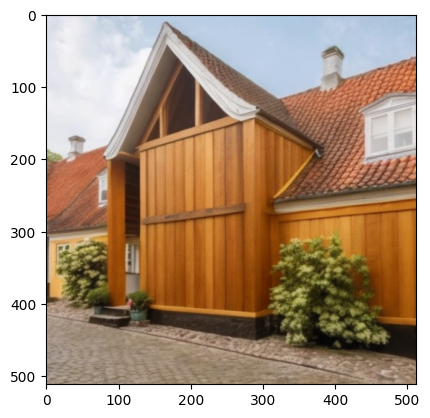

[-45.162]


Timestep:   0%|          | 0/20 [00:00<?, ?it/s]

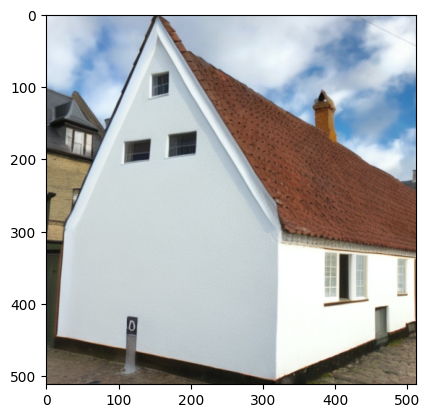

[-44.507]


Timestep:   0%|          | 0/20 [00:00<?, ?it/s]

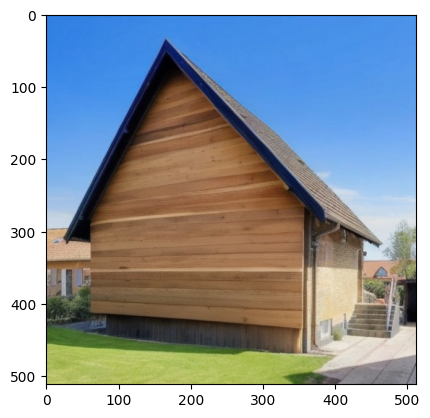

Epoch 0: Sampling:  50%|█████     | 1/2 [00:20<00:20, 20.15s/it]

[-33.493]


Timestep:   0%|          | 0/20 [00:00<?, ?it/s]

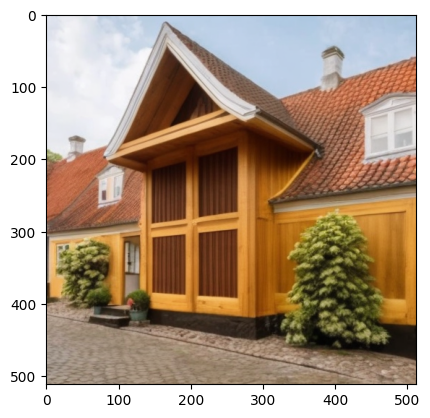

[-48.6]


Timestep:   0%|          | 0/20 [00:00<?, ?it/s]

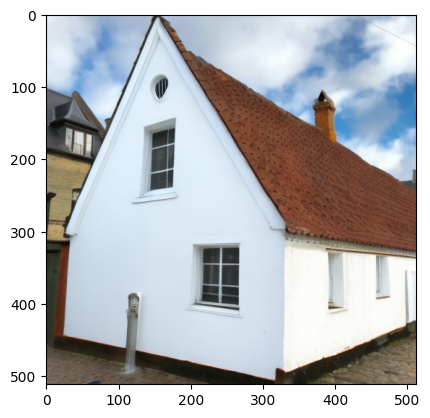

[-46.795]


Timestep:   0%|          | 0/20 [00:00<?, ?it/s]

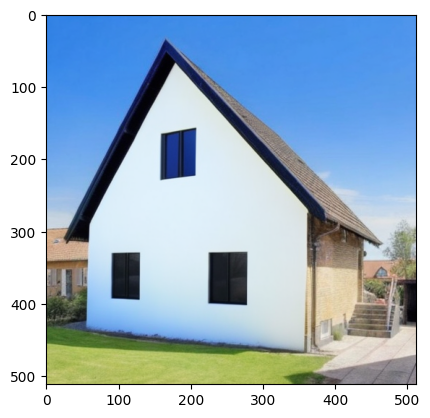

[-22.748]


Epoch 0.0: training:   0%|          | 0/6 [00:00<?, ?it/s]

latent_model_input.shape torch.Size([2, 4, 64, 64])
mask.shape torch.Size([2, 1, 64, 64])
masked_image_latents.shape torch.Size([2, 4, 64, 64])


Epoch 0.0: training:   0%|          | 0/6 [00:00<?, ?it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:208                                                                                  │
│                                                                                                  │
│   205 │   │   │   │   # backward pass                                                            │
│   206 │   │   │   │   accelerator.backward(loss)                                                 │
│   207 │   │   │   │   if accelerator.sync_gradients:                                             │
│ ❱ 208 │   │   │   │   │   accelerator.clip_grad_norm_(dppo_pipe.unet.parameters(), config.trai   │
│   209 │   │   │   │   optimizer.step()                                                           │
│   210 │   │   │   │   optimizer.zero_grad()                                                      │
│   211                                                                                            │
│                                                                                                  │
│ c:\Users\Facundo\AppData\Local\Programs\Python\Python310\lib\site-packages\accelerate\accelerato │
│ r.py:1817 in clip_grad_norm_                                                                     │
│                                                                                                  │
│   1814 │   │   │   # `accelerator.backward(loss)` is doing that automatically. Therefore, its i  │
│   1815 │   │   │   # We cannot return the gradient norm because DeepSpeed does it.               │
│   1816 │   │   │   return None                                                                   │
│ ❱ 1817 │   │   self.unscale_gradients()                                                          │
│   1818 │   │   return torch.nn.utils.clip_grad_norm_(parameters, max_norm, norm_type=norm_type)  │
│   1819 │                                                                                         │
│   1820 │   def clip_grad_value_(self, parameters, clip_value):                                   │
│                                                                                                  │
│ c:\Users\Facundo\AppData\Local\Programs\Python\Python310\lib\site-packages\accelerate\accelerato │
│ r.py:1780 in unscale_gradients                                                                   │
│                                                                                                  │
│   1777 │   │   │   for opt in optimizer:                                                         │
│   1778 │   │   │   │   while isinstance(opt, AcceleratedOptimizer):                              │
│   1779 │   │   │   │   │   opt = opt.optimizer                                                   │
│ ❱ 1780 │   │   │   │   self.scaler.unscale_(opt)                                                 │
│   1781 │                                                                                         │
│   1782 │   def clip_grad_norm_(self, parameters, max_norm, norm_type=2):                         │
│   1783 │   │   """                                                                               │
│                                                                                                  │
│ c:\Users\Facundo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\cuda\amp\grad_s │
│ caler.py:284 in unscale_                                                                         │
│                                                                                                  │
│   281 │   │   inv_scale = self._scale.double().reciprocal().float()                              │
│   282 │   │   found_inf = torch.full((1,), 0.0, dtype=torch.float32, device=self._scale.device   │
│   283 │   │                                                                                      │
│ ❱ 284 │   │   optimizer_state["found_inf_per_device"] = sel

In [22]:
import torch
from tqdm import tqdm


first_epoch = 0
global_step = 0

# generate negative prompt embeddings
neg_prompt_embed = dppo_pipe.text_encoder(
    dppo_pipe.tokenizer(
        [""],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=dppo_pipe.tokenizer.model_max_length,
    ).input_ids.to(accelerator.device)
)[0]

for epoch in range(first_epoch, config.num_epochs):

    generator = torch.Generator(device='cuda').manual_seed(42) # putting generator here to see the difference in the generated images at each epoch

    #################### SAMPLING ####################
    dppo_pipe.unet.eval()
    samples = []
    prompt_image_pairs = []

    for i in tqdm(range(config.sample.num_batches_per_epoch), desc=f"Epoch {epoch}: Sampling", leave=False):
        for batch in sampling_dataloader:

            with torch.cuda.amp.autocast():
                inpainting_output = dppo_pipe(
                    prompt_embeds=batch["prompt_embeds"],
                    image=batch["images"],
                    mask_image=batch["masks"],
                    num_inference_steps=config.sample.num_steps,
                    eta=config.sample.eta,
                    guidance_scale=config.sample.guidance_scale,
                    generator=generator,
                    output_type="pt",
                )

            gen_images = inpainting_output.images
            latents = inpainting_output.latents
            log_probs = inpainting_output.log_probs
            mask = inpainting_output.mask
            masked_image_latents = inpainting_output.masked_image_latents

            latents = torch.stack(latents, dim=1)  # (batch_size, num_steps + 1, ...)
            log_probs = torch.stack(log_probs, dim=1)  # (batch_size, num_steps, 1)
            timesteps = dppo_pipe.scheduler.timesteps.repeat(config.sample.batch_size, 1)  # (batch_size, num_steps)

            reward = reward_fn(scorer, gen_images)
            gen_images = convert_images(gen_images)
            plt.imshow(gen_images[0])
            plt.show()
            print(reward)

            samples.append(
                {
                    "prompt_ids": batch["prompt_ids"],
                    "prompt_embeds": batch["prompt_embeds"],
                    "timesteps": timesteps,
                    "latents": latents[:, :-1],  # each entry is the latent before timestep t
                    "next_latents": latents[:, 1:],  # each entry is the latent after timestep t
                    "mask": mask,
                    "masked_image_latents": masked_image_latents,
                    "log_probs": log_probs,
                    "rewards": reward,
                }
            )
            prompt_image_pairs.append((batch["prompts"], gen_images, reward))

    #################### TRAINING ####################

    # wait for all rewards to be computed
    for sample in tqdm(
        samples,
        desc="Waiting for rewards",
        disable=not accelerator.is_local_main_process,
        position=0,
    ):
        # accelerator.print(reward_metadata)
        sample["rewards"] = torch.as_tensor(sample["rewards"], device=accelerator.device)

    # collate samples into dict where each entry has shape (num_batches_per_epoch * sample.batch_size, ...)
    samples = {k: torch.cat([s[k] for s in samples]) for k in samples[0].keys()}

    rewards = samples["rewards"].cpu()

    # per-prompt mean/std tracking
    if config.per_prompt_stat_tracking:
        # gather the prompts across processes
        prompt_ids = accelerator.gather(samples["prompt_ids"]).cpu().numpy()
        prompts = dppo_pipe.tokenizer.batch_decode(prompt_ids, skip_special_tokens=True)
        advantages = stat_tracker.update(prompts, rewards)
    else:
        advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
    
    samples["advantages"] = (
            torch.as_tensor(advantages)
            .reshape(accelerator.num_processes, -1)[accelerator.process_index]
            .to(accelerator.device)
        )
    total_batch_size, num_timesteps = samples["timesteps"].shape


    from collections import defaultdict
    from ddim_with_logprob import ddim_step_with_logprob

    
    for inner_epoch in range(config.train.num_inner_epochs):
        # shuffle samples along batch dimension
        perm = torch.randperm(total_batch_size, device=accelerator.device)
        samples = {k: v[perm] for k, v in samples.items()}

        # shuffle along time dimension independently for each sample
        perms = torch.stack(
            [torch.randperm(num_timesteps, device=accelerator.device) for _ in range(total_batch_size)]
        )
        for key in ["timesteps", "latents", "next_latents", "log_probs"]:
            samples[key] = samples[key][torch.arange(total_batch_size, device=accelerator.device)[:, None], perms]

        # rebatch for training
        samples_batched = {k: v.reshape(-1, config.train.batch_size, *v.shape[1:]) for k, v in samples.items()}

        # dict of lists -> list of dicts for easier iteration
        samples_batched = [dict(zip(samples_batched, x)) for x in zip(*samples_batched.values())]

        # train
        dppo_pipe.unet.train()
        info = defaultdict(list)
        for i, sample in tqdm(
            list(enumerate(samples_batched)),
            desc=f"Epoch {epoch}.{inner_epoch}: training",
            position=0,
            disable=not accelerator.is_local_main_process,
        ):
            embeds = torch.cat([neg_prompt_embed, sample["prompt_embeds"]])
            mask = torch.cat([sample["mask"]] * 2) if config.train.cfg else timesteps
            masked_image_latents = torch.cat([sample["masked_image_latents"]] * 2) if config.train.cfg else masked_image_latents

            for j in tqdm(
                range(num_train_timesteps),
                desc="Timestep",
                position=1,
                leave=False,
                disable=not accelerator.is_local_main_process,
            ):
            
                with torch.cuda.amp.autocast():
                    latents = sample["latents"][:, j]
                    timesteps = sample["timesteps"][:, j]

                    timesteps = torch.cat([timesteps] * 2) if config.train.cfg else timesteps
                    latent_model_input = torch.cat([latents] * 2) if config.train.cfg else latents
                    latent_model_input = torch.cat([latent_model_input, mask, masked_image_latents], dim=1)

                    noise_pred = dppo_pipe.unet(
                            latent_model_input,
                            timesteps,
                            embeds,
                        ).sample

                    if config.train.cfg:
                        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                        noise_pred = noise_pred_uncond + config.sample.guidance_scale * (
                            noise_pred_text - noise_pred_uncond
                        )

                    # compute the log prob of next_latents given latents under the current model
                    _, log_prob = ddim_step_with_logprob(
                        dppo_pipe.scheduler,
                        noise_pred,
                        sample["timesteps"][:, j],
                        sample["latents"][:, j],
                        eta=config.sample.eta,
                        prev_sample=sample["next_latents"][:, j],
                    )

                # ppo logic
                advantages = torch.clamp(
                    sample["advantages"], -config.train.adv_clip_max, config.train.adv_clip_max
                )
                ratio = torch.exp(log_prob - sample["log_probs"][:, j])
                unclipped_loss = -advantages * ratio
                clipped_loss = -advantages * torch.clamp(
                    ratio, 1.0 - config.train.clip_range, 1.0 + config.train.clip_range
                )
                loss = torch.mean(torch.maximum(unclipped_loss, clipped_loss))

                # debugging values
                # John Schulman says that (ratio - 1) - log(ratio) is a better
                # estimator, but most existing code uses this so...
                # http://joschu.net/blog/kl-approx.html
                info["approx_kl"].append(0.5 * torch.mean((log_prob - sample["log_probs"][:, j]) ** 2))
                info["clipfrac"].append(torch.mean((torch.abs(ratio - 1.0) > config.train.clip_range).float()))
                info["loss"].append(loss)

                # backward pass
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(dppo_pipe.unet.parameters(), config.train.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                assert (j == num_train_timesteps - 1) and (
                    i + 1
                ) % config.train.gradient_accumulation_steps == 0
                # log training-related stuff
                info = {k: torch.mean(torch.stack(v)) for k, v in info.items()}
                info = accelerator.reduce(info, reduction="mean")
                info.update({"epoch": epoch, "inner_epoch": inner_epoch})
                accelerator.log(info, step=global_step)
                global_step += 1
                info = defaultdict(list)


In [23]:
"""del samples["rewards"]
del samples["prompt_ids"]""";

In [24]:
total_batch_size, num_timesteps = samples["timesteps"].shape
# assert total_batch_size == config.sample.batch_size * config.sample.num_batches_per_epoch
assert num_timesteps == config.sample.num_steps

In [25]:
sample["mask"].shape

torch.Size([1, 1, 64, 64])